# Assignment 4 (ML-II)

# Clustering Text (Example 4)

## Wali Ullah (09745)

In [80]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
import scipy.cluster.hierarchy as sch
from matplotlib import pyplot
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN
import gensim
from gensim import corpora

In [2]:
# Load Data
def load_data(file_name):
    def readcsv(file_name):
        return pd.read_csv(file_name)
    def readexcel(file_name):
        return pd.read_excel(file_name)
    func_map = {
        "csv": readcsv,
        "xlsx": readexcel,
    }
    
    # default reader = readcsv
    reader = func_map.get("csv")
    
    for k,v in func_map.items():
        if file_name.endswith(k):
            reader = v
            break
    return reader(file_name)


# Data Discription

The dataset consists of 13 year’s data which consists of 10 attributes for 568000 reviews. Due to the computational complexity, I am useing a random sample of 10,000 reviews for our analysis.

The dataset contains the following columns :

1.Id->Review for each ID

2.Product Id->Unique identifier for the product

3.User Id->Unique identifier for the user

4.Profile Name->A user who has given the review

5.Helpful Numerator->No. of users who found the review helpful

6.Helpful Denominator->No. of users who found the review helpful or not

7.Score->Five being is the highest rating and 1 being the lowest rating

8.Time->Date and time when the review was given

9.Summary->Summary of the review

10.Text->Review text

In [3]:
FILE_NAME = "reviews1.csv"
#FILE_NAME = "banksim_adj.csv"
#LABEL_COL = "fraud"
sample = load_data(FILE_NAME)
display(sample.head())
print(sample.shape)
print(sample.dtypes)

C:\Users\waliullah\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3418: DtypeWarning: Columns (1,2,3,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1.0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,5.0,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2.0,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,1.0,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3.0,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...
3,4.0,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,2.0,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient i...
4,5.0,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,5.0,1.350778e+09,Great taffy,Great taffy at a great price. There was a wid...


(556249, 10)
Id                        float64
ProductId                  object
UserId                     object
ProfileName                object
HelpfulnessNumerator      float64
HelpfulnessDenominator    float64
Score                     float64
Time                      float64
Summary                    object
Text                       object
dtype: object


In [4]:
#check the loaded data
print(sample.shape)

(556249, 10)


In [5]:
#look of the dataset
sample.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1.0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,5.0,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2.0,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,1.0,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3.0,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,4.0,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...
3,4.0,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,2.0,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient i...
4,5.0,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,5.0,1.350778e+09,Great taffy,Great taffy at a great price. There was a wid...


C:\Users\waliullah\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Score', ylabel='count'>

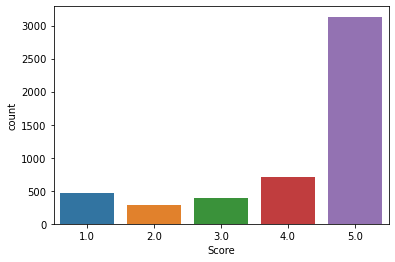

In [6]:
# Understand how customer ratings are distributed
import seaborn as sns
sns.countplot(sample.Score)

 # Data Cleaning

In [7]:
#converting the Numerical reviws to categorical reviews on codition above 3 are
#positive and below 3 are negative as reviews rating with 3 are not much useful
#for analysis

#function
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive
actualScore = sample['Score']
positiveNegative = actualScore.map(partition) 
sample['Score'] = positiveNegative

In [8]:
sample.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1.0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1.0,1.0,positive,1.303862e+09,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2.0,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0.0,0.0,negative,1.346976e+09,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3.0,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1.0,1.0,positive,1.219018e+09,"""Delight"" says it all",This is a confection that has been around a fe...
3,4.0,B000UA0QIQ,A395BORC6FGVXV,Karl,3.0,3.0,negative,1.307923e+09,Cough Medicine,If you are looking for the secret ingredient i...
4,5.0,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0.0,0.0,positive,1.350778e+09,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
# no of positive and negative reviews
sample["Score"].value_counts()
#here we can say it is a unbalanced data set

positive    555490
negative       759
Name: Score, dtype: int64

In [10]:
#dropping  the duplicates column if any using drop duplicates from pandas
sorted_data=sample.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [11]:
# no duplicate columns found
(final['Id'].size*1.0)/(sample['Id'].size*1.0)*100

0.8963611619975945

In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
# Help..Num is always less than Denom.. as Denom is people who upvote and donwvote
#Before understanding text preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

# after removing duplicate rows we found, 8346 positive and 1457 negative

(4985, 10)


positive    4231
negative     754
Name: Score, dtype: int64

C:\Users\waliullah\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Score', ylabel='count'>

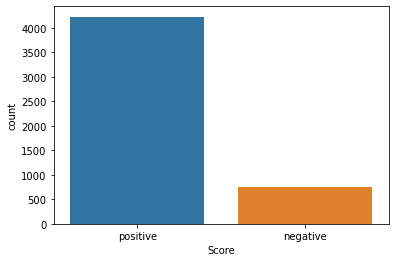

In [13]:
# After Removing Duplicate rows
import seaborn as sns
sns.countplot(final.Score)

# Text Processing

To make the text clean by removing HTML tag reviews, stopwords to segregate and adding timestamp

In [14]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

1
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [15]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer which is developed in recent years
stop=set(stopwords.words('english'))



def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'my', 'by', "mightn't", 't', 'theirs', 'herself', 'our', 'nor', 'here', 'he', 'won', 'under', 'each', 'who', 'off', "shouldn't", 'been', 'very', 'i', 'about', 'needn', "won't", 'were', 'had', 'if', 'be', 'couldn', 'any', 'once', 'doesn', "wouldn't", 'own', "don't", 'its', "couldn't", 'mustn', 'has', 'to', 'at', 'all', 'those', 'can', 'd', 'them', 'yours', "that'll", 'more', 'how', 'himself', "needn't", "you'd", 'not', 'ours', 'as', 'and', 'a', 'her', 'over', 'or', 'myself', "you've", 'of', 'is', 'their', 'from', 'are', 'we', "you'll", 'that', 'too', 're', 'me', 'where', 'for', 'such', 'mightn', 'shouldn', 'through', "she's", 'ain', 'do', 'yourselves', 'most', 'against', 'being', 'am', 'on', 'themselves', 'after', 'm', 'you', 'hers', "you're", 'an', 'don', 'no', 'hasn', 'but', 'into', 'your', 'which', 'didn', 'these', 'until', 'few', 'other', "wasn't", 'with', 'in', 'during', 'yourself', "didn't", "it's", 'wouldn', 'than', 'there', 'wasn', 'because', 's', "mustn't", 'o', 'will', 'just'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\waliullah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [17]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [18]:
final.shape # cleaned text column added

(4985, 11)

In [19]:
final.head(3) #below the processed review can be seen in the CleanedText Column 

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
2774,2775.0,B00002NCJC,A13RRPGE79XFFH,reader48,0.0,0.0,positive,1.281053e+09,Flies Begone,We have used the Victor fly bait for 3 seasons...,use victor fli bait season cant beat great pro...
2773,2774.0,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0.0,0.0,positive,1.282954e+09,thirty bucks?,Why is this $[...] when the same product is av...,product avail www amazon com victor trap unrea...
1243,1244.0,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10.0,10.0,positive,9.622368e+08,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...


In [20]:
# however, this is not required for clustering, just segregaring positive,negative and storing seperetly
data_pos = final[final["Score"] == "positive"]
data_neg = final[final["Score"] == "negative"]
final = pd.concat([data_pos, data_neg])
score =final["Score"]
final.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
2774,2775.0,B00002NCJC,A13RRPGE79XFFH,reader48,0.0,0.0,positive,1.281053e+09,Flies Begone,We have used the Victor fly bait for 3 seasons...,use victor fli bait season cant beat great pro...
2773,2774.0,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0.0,0.0,positive,1.282954e+09,thirty bucks?,Why is this $[...] when the same product is av...,product avail www amazon com victor trap unrea...
1243,1244.0,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10.0,10.0,positive,9.622368e+08,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
1244,1245.0,B00002Z754,A29Z5PI9BW2PU3,Robbie,7.0,7.0,positive,9.617184e+08,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...
3202,3203.0,B000084DVR,A3DKGXWUEP1AI2,"Glenna E. Bauer ""Puppy Mum""",3.0,3.0,positive,1.163030e+09,Premium Quality Dog Food!!!,We have been using this food for about 6 month...,use food month find excel fact two dog coton t...


In [21]:
#Converting the time frame and sorting in increasing order for easyness
final["Time"] = pd.to_datetime(final["Time"], unit = "s")
final= final.sort_values(by = "Time")
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
1244,1245.0,B00002Z754,A29Z5PI9BW2PU3,Robbie,7.0,7.0,positive,2000-06-23,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...
1243,1244.0,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10.0,10.0,positive,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
3782,3783.0,B00016UX0K,AF1PV3DIC0XM7,Robert Ashton,1.0,2.0,positive,2004-04-10,Classic Condiment,Mae Ploy Sweet Chili Sauce is becoming a stand...,mae ploy sweet chili sauc becom standard condi...
1205,1206.0,B005O072PC,A3BD5B8Y8MY25X,"J. L. K. ""special_k""",13.0,14.0,positive,2004-06-29,The best twice baked potatoes you'll ever have!,Perfect year round with just about any meat di...,perfect year round meat dish omaha steak twice...
1275,1276.0,B000WNJ73Q,A394MHK3CSDGUV,kaleinor,2.0,2.0,positive,2004-08-01,5 Woofs!,Five of my five dogs agree - they'd rather mun...,five five dog agre theyd rather munch liver bi...


#  Clustering

Find Clustering models for both Bag of words, term frequcny/ inverse document frequcny and avg word to vector

### K means using bag of words

In [22]:
# Generating bag of words features.
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
bow = count_vect.fit_transform(final['CleanedText'].values)
bow.shape

(4985, 8565)

In [23]:
bow

<4985x8565 sparse matrix of type '<class 'numpy.int64'>'
	with 150241 stored elements in Compressed Sparse Row format>

In [24]:
# to understand what kind of words generated as columns by BOW
terms = count_vect.get_feature_names()

In [25]:
#first 10 columns generated by BOW
terms[1:10]

['aback',
 'abandon',
 'abat',
 'abbi',
 'abbott',
 'abdomin',
 'abid',
 'abil',
 'abl']

In [26]:
#using all processes jobs=-1 and k means++ for starting initilization advantage
from sklearn.cluster import KMeans
model = KMeans(n_clusters = 10,init='k-means++', n_jobs = -1,random_state=99)
model.fit(bow)

C:\Users\waliullah\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(n_clusters=10, n_jobs=-1, random_state=99)

In [27]:
labels = model.labels_
cluster_center=model.cluster_centers_

In [28]:
cluster_center

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
from sklearn import metrics
silhouette_score = metrics.silhouette_score(bow, labels, metric='euclidean')

In [30]:
# which tells us that clusters are far away from each other 
silhouette_score

0.0738151157266508

In [31]:
# Giving Labels/assigning a cluster to each point/text 
df = final
df['Bow Clus Label'] = model.labels_ # the last column you can see the label numebers
df.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Bow Clus Label
1244,1245.0,B00002Z754,A29Z5PI9BW2PU3,Robbie,7.0,7.0,positive,2000-06-23,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...,4
1243,1244.0,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10.0,10.0,positive,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...,4


In [32]:
# How many points belong to each cluster -> using group by in pandas
df.groupby(['Bow Clus Label'])['Text'].count()

Bow Clus Label
0     120
1     182
2       1
3      25
4    3438
5      31
6     353
7     673
8      29
9     133
Name: Text, dtype: int64

In [33]:
#Refrence credit - to find the top 10 features of cluster centriod
#https://stackoverflow.com/questions/47452119/kmean-clustering-top-terms-in-cluster
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = count_vect.get_feature_names()
for i in range(10):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
        print()

Top terms per cluster:
Cluster 0: coffe
 tast
 flavor
 like
 cup
 decaf
 good
 tri
 drink
 use
Cluster 1: food
 dog
 eat
 love
 like
 newman
 one
 cat
 year
 bag
Cluster 2: egg
 allergi
 calcium
 formula
 babi
 phosphorus
 yolk
 dha
 food
 protein
Cluster 3: one
 oreo
 product
 like
 use
 eat
 make
 would
 get
 cake
Cluster 4: great
 tast
 love
 good
 like
 product
 flavor
 use
 one
 tri
Cluster 5: mix
 pancak
 make
 use
 recip
 product
 like
 tast
 waffl
 good
Cluster 6: chip
 flavor
 bag
 like
 tast
 salt
 good
 great
 potato
 love
Cluster 7: like
 tast
 use
 product
 one
 tri
 good
 flavor
 make
 water
Cluster 8: chip
 bag
 flavor
 potato
 kettl
 like
 tast
 brand
 salt
 good
Cluster 9: tea
 green
 like
 flavor
 tast
 drink
 use
 water
 tri
 bag


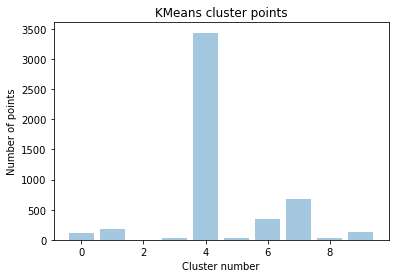

In [34]:
# visually how points or reviews are distributed across 10 clusters 
import matplotlib.pyplot as plt
plt.bar([x for x in range(10)], df.groupby(['Bow Clus Label'])['Text'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

In [35]:
# Reading a review which belong to each group.
for i in range(10):
    print("A review of assigned to cluster ", i)
    print("-" * 70)
    print(df.iloc[df.groupby(['Bow Clus Label']).groups[i][0]]['Text'])
    print('\n')
    print("_" * 70)

A review of assigned to cluster  0
----------------------------------------------------------------------
I LOVE THESE CHIPS, I HAVE THEM ON AUTO ORDER EVERY 2 MONTHS, THEY TASTE GREAT, I CAN NOT BELIVE THE WHOLE BAG HAS 100 CALORIES, I HAVE A BAG EVERY DAY, IT SURE HAS HELPED MY WEIGHT LOSS BY HAVEING THEM IN LITTLE BAGS, SO I DO NOT EAT A HUGE AMOUNT


______________________________________________________________________
A review of assigned to cluster  1
----------------------------------------------------------------------
Best Bit-O-Honey I have ever eaten.<br />I have always bought this product at a local grocery store and it was always hard, I figured it was suppose to be that way. But after eating the box I bought here I now know better; the candy was soft and delicious.<br />I plan to continue buying Bit-O-Honey from here.


______________________________________________________________________
A review of assigned to cluster  2
-----------------------------------------------

In [36]:
#considers sample of 3 random reviews for cluster 0

print(df.iloc[df.groupby(['Bow Clus Label']).groups[0][3]]['Text'])
print("_" * 70)
print(df.iloc[df.groupby(['Bow Clus Label']).groups[0][15]]['Text'])
print("_" * 70)
print(df.iloc[df.groupby(['Bow Clus Label']).groups[0][25]]['Text'])

I have nothing but good service ever since I started ordering from amazon.com.  Keep up the good work.
______________________________________________________________________
I am from England and I was raised on this custard. If you like vanilla custard/pudding you will love this. It's rich and creamy and has lots of vanilla taste.  I love that it comes in a big canister and I can make as much as I want to. I would never make a trifle with anything else.
______________________________________________________________________
It was shipped in a very nice package and I have no complain with the seller. My plant growing bigger and now I am looking for a bigger pot to transplant. It's good....if you are looking for a a workspace plant that needs minimal maintenance this is the plant you might need.


In [79]:
#consider sample of 3 random reviews for cluster 4

print(df.iloc[df.groupby(['Bow Clus Label']).groups[3][3]]['Text'])
print("_" * 70)
print(df.iloc[df.groupby(['Bow Clus Label']).groups[3][15]]['Text'])
print("_" * 70)
print(df.iloc[df.groupby(['Bow Clus Label']).groups[3][20]]['Text'])

fast and great service, my Cavashon Loves this low fat dog food. Thanks. Arrived in great condition, thank you thank you thank you
______________________________________________________________________
Tasty, convenient bars for people with celiac disease. They seem to have gotten smaller over time, but the taste and convenience outweigh the reduction in size (and the price).
______________________________________________________________________
I love these chips. They are so delicious, it is so hard to eat just one bag. All the flavors allow you to taste them all.  My favorite flavor is the cheese ones. Go ahead and try them.  They are so delicious.


In [38]:
#consider sample of 3 random reviews for cluster 4

print(df.iloc[df.groupby(['Bow Clus Label']).groups[5][3]]['Text'])
print("_" * 70)
print(df.iloc[df.groupby(['Bow Clus Label']).groups[5][15]]['Text'])
print("_" * 70)
print(df.iloc[df.groupby(['Bow Clus Label']).groups[5][25]]['Text'])

I was pleasantly surprised by the stronger than I expected ginger flavor in this product.  It is excellent, if you like ginger, try this.  Best on hot biscuits!  Update.  I've just reordered, wish they sold it by the gallon, its different, something you can't find locally and excellent.
______________________________________________________________________
The potato bread was easy to mix, rises well in my breadmaker, cooks as it should and best of all was very tasty. The bread has a near white bread texture, and was very good. I purchased all of the Hodgson mixes and this was one of my favorites.
______________________________________________________________________
My daughter loves these snacks and can't get them in China where she is working now so I ordered them for her. Very satisfied and she was very appreciative.


__Analysis of K means for BOW:__

__Of all the clusters, 0, 4 and 6 accounts to more % of reviews, undertsanding differences between these 3 clusters is key.
Also, the clusters 2 and 9 have only 1 review__ 

If we observe the top terms per cluster, The cluster 4 which consists of LIKE AND LOVE, which are top centroid features and can say this cluster consists of all positive reviews, let us obersve few reviews of each cluster and try to understand the differences

By reading the cluster 2 and 9 which contains only one review, which is clearlt negative reviews and we can conluded customers
didnt liked the product at all and not word is used extensively

By reading random reviews of cluster 0, we can easily say that these reviews are extremly positive of the product usage and customers are very happy with the product

By reading random reviews of cluster 4, we can  say that the key word __BUT__ is repeating acorss the review which indicates some kind of peopel agree with most of the things related to the products but their is something which is slightyly disagree with product quality or delivery or  some thing less than their expectation



##  K means using TFIDF

In [39]:
#tfidf vector initililization
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(final['CleanedText'].values)
tfidf.shape

(4985, 8565)

In [40]:
from sklearn.cluster import KMeans
model_tf = KMeans(n_clusters = 10, n_jobs = -1,random_state=99)
model_tf.fit(tfidf)

C:\Users\waliullah\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


KMeans(n_clusters=10, n_jobs=-1, random_state=99)

In [41]:
labels_tf = model_tf.labels_
cluster_center_tf=model_tf.cluster_centers_

In [42]:
cluster_center_tf

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00061507,
        0.        ]])

In [43]:
# to understand what kind of words generated as columns by BOW
terms1 = tfidf_vect.get_feature_names()

In [44]:
terms1[1:10]

['aback',
 'abandon',
 'abat',
 'abbi',
 'abbott',
 'abdomin',
 'abid',
 'abil',
 'abl']

In [45]:
from sklearn import metrics
silhouette_score_tf = metrics.silhouette_score(tfidf, labels_tf, metric='euclidean')

In [46]:
silhouette_score_tf

0.016420551824604532

In [47]:
# Giving Labels/assigning a cluster to each point/text 
df1 = df
df1['Tfidf Clus Label'] = model_tf.labels_
df1.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Bow Clus Label,Tfidf Clus Label
1244,1245.0,B00002Z754,A29Z5PI9BW2PU3,Robbie,7.0,7.0,positive,2000-06-23,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...,4,6
1243,1244.0,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10.0,10.0,positive,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...,4,6
3782,3783.0,B00016UX0K,AF1PV3DIC0XM7,Robert Ashton,1.0,2.0,positive,2004-04-10,Classic Condiment,Mae Ploy Sweet Chili Sauce is becoming a stand...,mae ploy sweet chili sauc becom standard condi...,4,6
1205,1206.0,B005O072PC,A3BD5B8Y8MY25X,"J. L. K. ""special_k""",13.0,14.0,positive,2004-06-29,The best twice baked potatoes you'll ever have!,Perfect year round with just about any meat di...,perfect year round meat dish omaha steak twice...,4,6
1275,1276.0,B000WNJ73Q,A394MHK3CSDGUV,kaleinor,2.0,2.0,positive,2004-08-01,5 Woofs!,Five of my five dogs agree - they'd rather mun...,five five dog agre theyd rather munch liver bi...,4,6


In [48]:
# How many points belong to each cluster ->

df1.groupby(['Tfidf Clus Label'])['Text'].count()

Tfidf Clus Label
0     279
1     308
2     326
3     283
4     502
5     289
6    2086
7     455
8      68
9     389
Name: Text, dtype: int64

In [49]:
#Refrence credit - to find the top 10 features of cluster centriod
#https://stackoverflow.com/questions/47452119/kmean-clustering-top-terms-in-cluster
print("Top terms per cluster:")
order_centroids = model_tf.cluster_centers_.argsort()[:, ::-1]
for i in range(10):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms1[ind], end='')
        print()

Top terms per cluster:
Cluster 0: tea
 green
 drink
 ice
 tast
 like
 flavor
 use
 water
 love
Cluster 1: pancak
 mix
 waffl
 gluten
 bisquick
 make
 free
 use
 product
 biscuit
Cluster 2: coffe
 tast
 decaf
 cup
 flavor
 like
 bitter
 strong
 smooth
 good
Cluster 3: chocol
 hot
 cocoa
 cup
 tast
 keurig
 tri
 dark
 good
 grove
Cluster 4: love
 great
 product
 snack
 flavor
 tast
 eat
 good
 one
 get
Cluster 5: dog
 food
 newman
 love
 eat
 organ
 cat
 feed
 year
 treat
Cluster 6: like
 tast
 good
 product
 flavor
 use
 one
 tri
 order
 would
Cluster 7: chip
 flavor
 bag
 salt
 potato
 kettl
 like
 vinegar
 great
 love
Cluster 8: popcorn
 pop
 kernel
 popper
 white
 hull
 small
 corn
 amish
 tender
Cluster 9: store
 amazon
 price
 find
 local
 product
 groceri
 buy
 good
 order


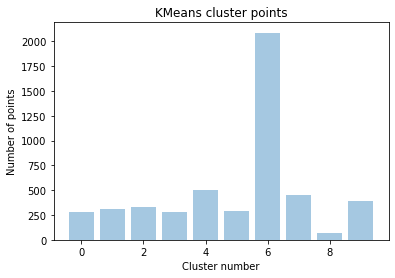

In [50]:
# visually how points or reviews are distributed across 10 clusters 

plt.bar([x for x in range(10)], df1.groupby(['Tfidf Clus Label'])['Text'].count(), alpha = 0.4)
plt.title('KMeans cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

In [51]:
# Reading a review which belong to each group.
for i in range(10):
    print("4 review of assigned to cluster ", i)
    print("-" * 70)
    print(df1.iloc[df1.groupby(['Tfidf Clus Label']).groups[i][5]]['Text'])
    print('\n')
    print(df1.iloc[df1.groupby(['Tfidf Clus Label']).groups[i][10]]['Text'])
    print('\n')
    print(df1.iloc[df1.groupby(['Tfidf Clus Label']).groups[i][20]]['Text'])
    print('\n')
    print("_" * 70)

4 review of assigned to cluster  0
----------------------------------------------------------------------
I'm trying several of the Wu Yi teas. I like this one particularly because of the subtle citrus taste. It also has a natural sweetness.<br /><br />The ingredients include Organic Wu-Li Cliff Oolong Tea (700 mg), Organic Black Tea (600 mg), Organic Green Tea Extract (100 mg), Proprietary blend (600 mg), plus some Ginseng (panax), Orange Peel, Lemon Grass, and Guarana. Other Ingredients: Natual Orange and Citrus flavors.<br /><br />My goal is to drink more tea and less coffee. I am enjoying trying a different kind of tea every day. I'll be coming back to this one.


The Price is great, The serving is just right for a snack, and ITS A COOKIE. Buy a bunch and they send it to your house!!


thank you for this product - we use it all the time and appreciate your promptness and the price was excellent.  Thanks again.


______________________________________________________________________

__Analysis of K means for TF_IDF:__

__Of all the cluster 4  accounts to more % of reviews i,e above 4000.

If we observe the top terms per cluster, The clusters based on the products and product wise like and dislikes.
for example, if we oberve cluster 8, the reviews talk more about chips, potatos, and other products which are like snacks

In these, its better to understand the cluster center top features rather than individual reviews.

# Average Word to Vector

In [52]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [53]:
print(final['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

realli good idea final product outstand use decal car window everybodi ask bought decal made two thumb
*****************************************************************
['realli', 'good', 'idea', 'final', 'product', 'outstand', 'use', 'decal', 'car', 'window', 'everybodi', 'ask', 'bought', 'decal', 'made', 'two', 'thumb']


In [54]:

# removing html tags and apostrophes if present.
import re
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [55]:
i=0
list_of_sent_train=[]
for sent in final['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

In [ ]:
vector_size=100

In [57]:
import gensim
# Training the wor2vec model using train dataset
w2v_model=gensim.models.Word2Vec(list_of_sent_train, vector_size=100, workers=4)

In [58]:
import numpy as np
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this train
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.array(sent_vectors)
sent_vectors = np.nan_to_num(sent_vectors)
sent_vectors.shape


(4985, 100)

## K Means CLustering for Avg word to vectors

In [59]:
# Number of clusters to check.
num_clus = [x for x in range(3,11)]
num_clus

[3, 4, 5, 6, 7, 8, 9, 10]

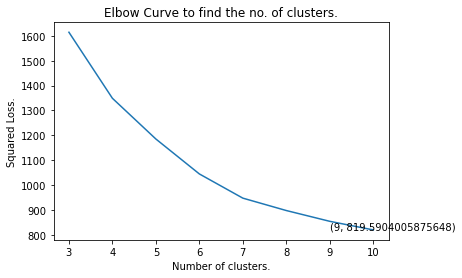

The optimal number of clusters obtained is -  9
The loss for optimal cluster is -  819.5904005875648


In [60]:
# Choosing the best cluster using Elbow Method.
# source credit,few parts of min squred loss info is taken from different parts of the stakoverflow answers.
# this is used to understand to find the optimal clusters in differen way rather than used in BOW, TFIDF
squared_errors = []
for cluster in num_clus:
    kmeans = KMeans(n_clusters = cluster).fit(sent_vectors) # Train Cluster
    squared_errors.append(kmeans.inertia_) # Appending the squared loss obtained in the list
    
optimal_clusters = np.argmin(squared_errors) + 2 # As argmin return the index of minimum loss. 
plt.plot(num_clus, squared_errors)
plt.title("Elbow Curve to find the no. of clusters.")
plt.xlabel("Number of clusters.")
plt.ylabel("Squared Loss.")
xy = (optimal_clusters, min(squared_errors))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.show()

print ("The optimal number of clusters obtained is - ", optimal_clusters)
print ("The loss for optimal cluster is - ", min(squared_errors))

In [61]:
# Training the best model --
from sklearn.cluster import KMeans
model2 = KMeans(n_clusters = optimal_clusters)
model2.fit(sent_vectors)

KMeans(n_clusters=9)

In [62]:
word_cluster_pred=model2.predict(sent_vectors)
word_cluster_pred_2=model2.labels_
word_cluster_center=model2.cluster_centers_

In [63]:
word_cluster_center[1:2]

array([[ 2.97770039e-01,  4.33285802e-01,  1.04807388e-03,
         1.41850606e-01,  4.85069192e-02, -4.39646394e-01,
         3.45700605e-01,  3.93962006e-01, -2.87123992e-01,
         9.05883804e-04,  1.95094611e-01, -2.04462879e-01,
         6.42368877e-02, -1.03781047e-01,  5.39754948e-02,
        -2.22620047e-01,  1.54635033e-01, -4.82459264e-01,
        -1.52842011e-01, -8.27133050e-01,  1.04009122e-01,
         8.03299383e-02, -9.65052480e-02, -7.62683143e-03,
        -4.54422366e-01, -4.99152779e-03, -2.23128314e-01,
        -2.52930300e-01, -3.00263015e-02, -1.01688197e-01,
         2.90673683e-01,  9.25762006e-02, -5.70009608e-02,
        -5.53611791e-02, -1.39321250e-01,  4.17029860e-01,
        -1.72431287e-01, -1.43766007e-01, -1.35696035e-01,
        -7.84194974e-01,  5.75856137e-02, -3.76448343e-01,
        -1.25271509e-01,  1.27192182e-01,  2.27435965e-01,
        -1.10459405e-02, -3.71644328e-01,  2.07651520e-02,
         3.23662472e-01,  1.66144826e-01,  2.81013745e-0

In [64]:
# Giving Labels/assigning a cluster to each point/text 
dfa = df1
dfa['AVG-W2V Clus Label'] = model2.labels_
dfa.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Bow Clus Label,Tfidf Clus Label,AVG-W2V Clus Label
1244,1245.0,B00002Z754,A29Z5PI9BW2PU3,Robbie,7.0,7.0,positive,2000-06-23,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...,4,6,2
1243,1244.0,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10.0,10.0,positive,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...,4,6,2


In [65]:
# How many points belong to each cluster ->
dfa.groupby(['AVG-W2V Clus Label'])['Text'].count()

AVG-W2V Clus Label
0     863
1     295
2    1002
3     223
4     357
5     294
6     398
7    1202
8     351
Name: Text, dtype: int64

In [66]:
# Reading a review which belong to each group.
for i in range(optimal_clusters):
    print("A review of assigned to cluster ", i)
    print("-" * 70)
    print(dfa.iloc[dfa.groupby(['AVG-W2V Clus Label']).groups[i][0]]['Text'])
    print('\n')
    print(dfa.iloc[dfa.groupby(['AVG-W2V Clus Label']).groups[i][1]]['Text'])
    print('\n')
    print("_" * 70)

A review of assigned to cluster  0
----------------------------------------------------------------------
I was given a pack of this coffee as a gift and it had been sitting around for quite a while (over a year) when I decided to try it.  It was without a doubt one of the best coffees that I have tasted.  Very smooth and flavorful.  I would highly recommend this.  After that I ordered a supply from Amazon. They are vacuum packed (I believe much better than store bought coffee).  I may try the decaf version of this to see how that tastes.


I love this stuff.  I put it over chicken and even steaks.  It's very sweet, and just a bit spicy.  Just a little goes a long way.


______________________________________________________________________
A review of assigned to cluster  1
----------------------------------------------------------------------
They are OK, but my husband only eats them when we are in car. We keep them there for a celiac snack. (Hard to find when roaming around.) He wo

## Clustering DBSCAN

In [67]:
from sklearn.cluster import DBSCAN

In [68]:
# Computing 200th Nearest neighbour distance
minPts = 2 * 100
# Lower bound function copied from -> https://gist.github.com/m00nlight/0f9306b4d4e61ba0195f
def lower_bound(nums, target): # This function return the number in the array just greater than or equal to itself.
    l, r = 0, len(nums) - 1
    while l <= r: # Binary searching.
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l

def compute200thnearestneighbour(x, data): # Returns the distance of 200th nearest neighbour.
    dists = []
    for val in data:
        dist = np.sum((x - val) **2 ) # computing distances.
        if(len(dists) == 200 and dists[199] > dist): # If distance is larger than current largest distance found.
            l = int(lower_bound(dists, dist)) # Using the lower bound function to get the right position.
            if l < 200 and l >= 0 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()
    
    return dists[199] # Dist 199 contains the distance of 200th nearest neighbour.

In [69]:
# Computing the 200th nearest neighbour distance of some point the dataset:
twohundrethneigh = []
for val in sent_vectors[:1500]:
    twohundrethneigh.append( compute200thnearestneighbour(val, sent_vectors[:1500]) )
twohundrethneigh.sort()

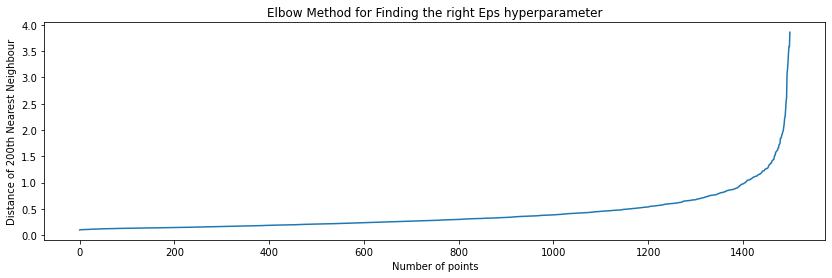

In [70]:

# Plotting for the Elbow Method :
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter")
plt.plot([x for x in range(len(twohundrethneigh))], twohundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.show()


Conclusions for Elbow Method

The Knee point seems to be 5. So Eps = 5

In [71]:
# Training DBSCAN :
model = DBSCAN(eps = 5, min_samples = minPts, n_jobs=-1)
model.fit(sent_vectors)

DBSCAN(eps=5, min_samples=200, n_jobs=-1)

In [72]:

dfdb = dfa
dfdb['AVG-W2V Clus Label'] = model.labels_
dfdb.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Bow Clus Label,Tfidf Clus Label,AVG-W2V Clus Label
1244,1245.0,B00002Z754,A29Z5PI9BW2PU3,Robbie,7.0,7.0,positive,2000-06-23,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...,4,6,0
1243,1244.0,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10.0,10.0,positive,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...,4,6,0


In [73]:
dfdb.groupby(['AVG-W2V Clus Label'])['Id'].count()

AVG-W2V Clus Label
0    4985
Name: Id, dtype: int64

# Clustering Hierarchical

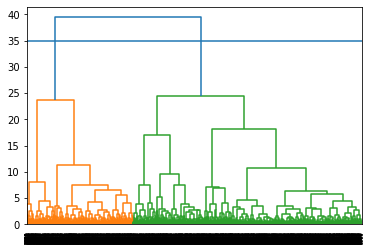

In [74]:
import scipy
from scipy.cluster import hierarchy
dendro=hierarchy.dendrogram(hierarchy.linkage(sent_vectors,method='ward'))
plt.axhline(y=35)# cut at 30 to get 5 clusters

In [75]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  #took n=5 from dendrogram curve 
Agg=cluster.fit_predict(sent_vectors)

In [76]:
# Giving Labels/assigning a cluster to each point/text 
aggdfa = dfdb
aggdfa['AVG-W2V Clus Label'] = cluster.labels_
aggdfa.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,Bow Clus Label,Tfidf Clus Label,AVG-W2V Clus Label
1244,1245.0,B00002Z754,A29Z5PI9BW2PU3,Robbie,7.0,7.0,positive,2000-06-23,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...,4,6,2
1243,1244.0,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10.0,10.0,positive,2000-06-29,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...,4,6,2


In [77]:
# How many points belong to each cluster ->
aggdfa.groupby(['AVG-W2V Clus Label'])['Text'].count()

AVG-W2V Clus Label
0    1065
1    1169
2    1933
3     414
4     404
Name: Text, dtype: int64

In [78]:
# Reading a review which belong to each group.
for i in range(5):
    print("2 reviews of assigned to cluster ", i)
    print("-" * 70)
    print(aggdfa.iloc[aggdfa.groupby(['AVG-W2V Clus Label']).groups[i][0]]['Text'])
    print('\n')
    print(aggdfa.iloc[aggdfa.groupby(['AVG-W2V Clus Label']).groups[i][1]]['Text'])
    print('\n')
    print("_" * 70)

2 reviews of assigned to cluster  0
----------------------------------------------------------------------
They are OK, but my husband only eats them when we are in car. We keep them there for a celiac snack. (Hard to find when roaming around.) He won't eat them otherwise. They are definitely raspberry, but are kind of dry.<br />  We have never tried any other snack bars, so in all honesty they may be the norm. I don't know.<br />  We DO like Enjoy Life's other products.<br />  They are GF, have no MSG or related products or aspartates.


the pop chips are really incredible. They are very flavorful and crispy. My Favorite is the BBQ, but that is just me, they are all good. I would highly recommend these to anyone who is watching their weight of just for overall better health.


______________________________________________________________________
2 reviews of assigned to cluster  1
----------------------------------------------------------------------
I love this stuff.  I put it over

# Conclusion
Kmeans for bag of words and TFIDF
1. By using Elbow method, we generated optimal 10 clusters for both the bag of words and tfidf techniques
2. In both the cases, one cluster accounts around 6000 reviews which is large chunk from 10k reviews and rest are distributed unevenly
3. we can ignore 2 clusters or keep 2 clusters depending upon the business goal for bag of words generation as both contain only 1 review

Final Observations:

FOR TFIDF K means is best for identification than K MEANS for BOW, all the clusters are clearly refelcting they were grouped based on the categories/products. However, K means did best on the cluster centers top terms but however when we caopare reviews , few places it is not correalting.

DBSCAN is very poorly performining on the 10k columns as it is grouping all reviews in one cluster

Hierarchical, for BOW and TFIDF, we cannot identify the clusters and not divded unevenly, but for avg word to vectors all are grouped and divided evenly. It is very difficult to identify the type of reveiws based on Hirarchial formation.



